# apply instruments settings

In [1]:
import time
import sys
import os
path_project = "\\".join(os.getcwd().split("\\")[:-1])
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, path_project)

from hardware.pulser.pulser import PulseGenerator, OutputState, TriggerStart, TriggerRearm, HIGH, LOW, INF
from hardware.laser.laser import LaserControl
from hardware.mw.mwsynthesizer import Synthesizer

from hardware import config_custom as hdc

import nidaqmx
from nidaqmx.constants import TerminalConfiguration, VoltageUnits, Edge, AcquisitionType, READ_ALL_AVAILABLE
# from nidaqmx.constants import LogicFamily 
# TWO_POINT_FIVE_V, THREE_POINT_THREE_V, FIVE_V
# from nidaqmx import stream_readers 
from nidaqmx.stream_readers import AnalogSingleChannelReader

import numpy as np
import matplotlib.pyplot as plt

In [416]:
mwsyn.close()
laser.close()

In [500]:
# connect to devices
pg  = PulseGenerator(ip=hdc.PS_IP, chmap=hdc.PS_chmap) 
mwsyn = Synthesizer(hdc.VDISYN_SN, 
                    vidpid=hdc.VDISYN_VIDPID,
                    baudrate=hdc.VDISYN_BAUD, 
                    timeout=5, 
                    write_timeout=5)
# mwsyn.reboot()
laser = LaserControl(hdc.LASER_SN)
laser.open()
# mwsyn.close()
# laser.close()


Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 169.254.8.2
Pulse Streamer 8/2 firmware: v1.7.2
Client software: v1.7.0
VDI Sythesizer Serail Port Open


# Set parameters

In [501]:
current_percent = 90.05
laser.laser_off()
laser.set_analog_control_mode("current")
laser.set_modulation_state("Pulsed")
laser.set_diode_current(current_percent, save_memory=False)

In [480]:
# laserpower = 145.0
# laser.laser_off()
# laser.set_analog_control_mode("power")
# laser.set_modulation_state("CW")
# laser.set_laser_power(laserpower, save_memory=False)
# laser.laser_on()

In [502]:
f_NVguess = 398.5607725381851
f_NVguess = 398.5547716319561
# f_NVguess = 392.83677300810814
f_detune = 0.5E-3
f_NVguess = 392.8397714495659+f_detune
freq = f_NVguess/24.0

errorbyte, freq_actual = mwsyn.cw_frequency(freq)
print(f"CW Freqeuncy Setting Sent:{freq} GHz")
print(f"Actual Output CW Freqeuncy :{freq_actual} GHz")

CW Freqeuncy Setting Sent:16.368344643731913 GHz
Actual Output CW Freqeuncy :16.368344642221928 GHz


In [503]:
DAQclockbase = 100.00/1E3 # GHz
DAQtimebase = 1.0/DAQclockbase #ns
laser_init = 6400
wait_init = 800
pihalf = 400.0
fid_dur_start = 10.0
fid_dur_stop = 64010.0
fid_dur_step = 40
fid_dur = np.arange(fid_dur_start, fid_dur_stop+fid_dur_step, fid_dur_step)
# fid_dur = np.geomspace(fid_dur_start, fid_dur_stop, 320, endpoint=True)
# rounding is IMPORTANT!!
# mw_dur = np.round(DAQclockbase*mw_dur)*DAQtimebase # round to DAQ timebase
fid_dur = np.round(fid_dur) # round to PS timebase
fid_dur_stop = fid_dur[-1]
fid_dur_start = fid_dur[0]
wait_read = 500
laser_read = 800

# here is to fix the timing
totaltime_max = laser_init+wait_init+pihalf+fid_dur_stop+pihalf+wait_read+laser_read
tbmultiple = int(DAQclockbase*totaltime_max+1)
sampling_rate = DAQclockbase/tbmultiple
sampletime = round(1.0/sampling_rate)
samplerate = 1.0/sampletime #GHz
padding_fix = sampletime-totaltime_max
padding = padding_fix+fid_dur_stop-fid_dur # depends on MW duration
num_pt = len(fid_dur)

assert np.all(padding+fid_dur+laser_init+wait_init+pihalf*2+wait_read+laser_read == sampletime)
assert padding_fix >= 0


In [504]:
# readoffset = DAQtimebase*30
delaydiff = DAQtimebase*15.0
readoffset = DAQtimebase*25.0
# delaydiff = DAQtimebase*0.0
# readoffset = laser_read - 20
daqpadding = sampletime - (laser_read - readoffset - delaydiff)
daqpadding = int(DAQclockbase*daqpadding)/DAQclockbase
# daqdelay = DAQtimebase*20.0
daqdelay = 0.0
daqtriggerdelay = DAQtimebase*0.0
# daqpadding = 1.0/clock_rate*1.0
# daqpadding = int(clock_rate*(1.0/sampling_rate-(laser_read-250.0)))/clock_rate
# daqpadding = 0.0


seq_daqtrig = [(daqdelay, LOW)] + [(daqtriggerdelay, LOW)] + [(daqpadding-DAQclockbase*10, LOW)] + [(sampletime, HIGH), (sampletime*(num_pt*2 - 1) - daqtriggerdelay-daqpadding+DAQclockbase*10, LOW)]
# seq_clock = [(0.5/clock_rate, HIGH),(0.5/clock_rate, LOW)]*(num_pt*2*clockmultiple+int(daqpadding*clock_rate))
# seq_clock = [(daqpadding, LOW)] + [(0.5/clock_rate, HIGH),(0.5/clock_rate, LOW)]*(num_pt*2*clockmultiple)
seq_clock = [(daqdelay, LOW)] + [(daqpadding, LOW),(sampletime-daqpadding, HIGH)]*num_pt*2
# seq_clock = [(0.5/clock_rate, HIGH),(0.5/clock_rate, LOW)]

seq_laser = []
seq_mwA = []
seq_mwB = []
skip = 0
seq_laser_sub_alloff = [(padding[-1], LOW), (laser_init, LOW), (wait_init, LOW), (pihalf, LOW), (fid_dur[-1], LOW), (pihalf, LOW), (wait_read, LOW), (laser_read, LOW)]
# for mwd, pd in zip(mw_dur, padding):
for ii in range(len(fid_dur)-skip):
    fidd = fid_dur[ii]
    pd = padding[ii]
    seq_laser_sub = [(pd, LOW), (laser_init, HIGH), (wait_init, LOW), 
                     (pihalf, LOW), (fidd, LOW), (pihalf, LOW), 
                     (wait_read, LOW), (laser_read, HIGH)]
    seq_mwA_sub = [(pd, LOW), (laser_init, LOW), (wait_init, LOW), 
                   (pihalf, HIGH), (fidd, LOW), (pihalf, HIGH), 
                   (wait_read, LOW), (laser_read, LOW)]
    seq_mwA_noMW_sub = [(pd, LOW), (laser_init, LOW), (wait_init, LOW), 
                   (pihalf, LOW), (fidd, LOW), (pihalf, LOW), 
                   (wait_read, LOW), (laser_read, LOW)]
    # seq_laser_sub = [(laser_init, HIGH), (wait_init, LOW), (mwd, LOW), (wait_read, LOW), (laser_read, HIGH), (pd, LOW)]
    # seq_mwA_sub = [(laser_init, LOW), (wait_init, LOW), (mwd, HIGH), (wait_read, LOW), (laser_read, LOW), (pd, LOW)]
    # seq_mwA_noMW_sub = [(laser_init, LOW), (wait_init, LOW), (mwd, LOW), (wait_read, LOW), (laser_read, LOW), (pd, LOW)]
    seq_laser += seq_laser_sub + seq_laser_sub
    # seq_laser += seq_laser_sub + seq_laser_sub_alloff
    seq_mwA += seq_mwA_sub + seq_mwA_noMW_sub
    seq_mwB += seq_mwA_noMW_sub + seq_mwA_noMW_sub
    # seq_mwA += seq_mwA_sub + seq_mwA_sub
    # seq_mwA += seq_mwA_noMW_sub + seq_mwA_noMW_sub
    # seq_mwA += seq_mwA_sub + seq_mwA_sub
seq_laser += (seq_laser_sub_alloff + seq_laser_sub_alloff)*skip
seq_mwA += (seq_mwA_noMW_sub + seq_mwA_noMW_sub)*skip
seq_mwB += (seq_mwA_noMW_sub + seq_mwA_noMW_sub)*skip
seq_laser +=  [(daqdelay, LOW)]
seq_mwA +=  [(daqdelay, LOW)]
seq_mwB +=  [(daqdelay, LOW)]
# seq_laser = [(daqtrigdelay,LOW)] + seq_laser
# seq_laser = [(0.5/clock_rate, HIGH),(0.5/clock_rate, HIGH)]*(num_pt*2*clockmultiple+int(daqtrigdelay*clock_rate))
# seq_mwA = [(daqtrigdelay,LOW)] + seq_mwA
# seq_laser += [(daqpadding, LOW)]
# seq_mwA += [(daqpadding, LOW)]

rrr = 8
pg.setDigital("laser", seq_laser*rrr)
pg.setDigital("mw_A", seq_mwA*rrr)
pg.setDigital("mw_B", seq_mwB*rrr)
# pg.setDigital("laser", seq_mwA)
# pg.setDigital("mw_A", seq_laser)
pg.setDigital("daqtrig", seq_daqtrig*rrr)
pg.setDigital("clock", seq_clock*rrr)
pg.setTrigger(start=TriggerStart.SOFTWARE, rearm=TriggerRearm.MANUAL)
assert round(np.sum(np.array(seq_laser)[:, 0])) == round(np.sum(np.array(seq_mwA)[:, 0])) == round(np.sum(np.array(seq_daqtrig)[:, 0])) == round(np.sum(np.array(seq_clock)[:, 0]))
assert sampletime > daqpadding + 10

In [505]:
aa = np.sum(np.array(seq_laser)[:, 0])
print(f"Total Seq. Time: {np.sum(aa)}ns")
aa = np.array(seq_mwA)[:, 0]
print(f"Total Seq. Time: {np.sum(aa)}ns")
aa = np.array(seq_daqtrig)[:, 0]
print(f"Total Seq. Time: {np.sum(aa)}ns")
aa = np.array(seq_clock)[:, 0]
print(f"Total Seq. Time: {np.sum(aa)}ns")

Total Seq. Time: 234770640.0ns
Total Seq. Time: 234770640.0ns
Total Seq. Time: 234770640.0ns
Total Seq. Time: 234770640.0ns


In [506]:
# signal reading parameters
min_volt = -0.001 # [V]
max_volt = 0.003
samplerate_read = samplerate*1E9 # 500kHz .max ext clock rate of NI6343, check it by yourself!
num_readsample = num_pt*2
timeout_read = max(2*num_readsample/samplerate_read, 10)
buffer_readpoint = np.zeros(num_readsample, dtype=np.float64, order='C')

readtask = nidaqmx.Task("readsignal")
# readtask.close()
readtask.ai_channels.add_ai_voltage_chan(
            hdc.DAQch_APD,"",
            # TerminalConfiguration.RSE,
            TerminalConfiguration.DIFF,
            min_volt,max_volt,
            VoltageUnits.VOLTS
        )
# readtask.timing.cfg_samp_clk_timing(samplerate_read, source="", active_edge=Edge.RISING, sample_mode=AcquisitionType.FINITE, samps_per_chan=num_readsample)
readtask.timing.cfg_samp_clk_timing(
    samplerate_read, 
    source=hdc.DAQch_Clock, 
    active_edge=Edge.RISING, 
    sample_mode=AcquisitionType.CONTINUOUS, 
    # sample_mode=AcquisitionType.FINITE, 
    samps_per_chan=num_readsample)
read_trig = readtask.triggers.start_trigger
read_trig.cfg_dig_edge_start_trig(hdc.DAQch_Trig, Edge.RISING)

reader = AnalogSingleChannelReader(readtask.in_stream)
reader.read_all_avail_samp  = True

In [486]:
readtask.close()

# Start measurement


In [507]:
laser.laser_on() # turn on laser

In [508]:
pg.stream(n_runs=INF)
pg.startNow()
# signal = np.zeros(num_pt)
# background = np.zeros(num_pt)
# repeat measurement

signal_av = np.zeros(num_pt, dtype=np.float64, order='C')
background_av = np.zeros(num_pt, dtype=np.float64, order='C')
readtask.start() # ready to read data
read_duration = 3600  # read data for 5 seconds
start_time = time.time()
num_repeat = 0
while time.time() - start_time < read_duration:
# for kkk in range(num_repeat):
    # readtask.start() # ready to read data
    num_read = reader.read_many_sample(
            buffer_readpoint,
            num_readsample,
            timeout_read
        )
    # readtask.wait_until_done(timeout=timeout_read) # block the code below, optional
    signal_av += np.copy(buffer_readpoint[0::2])
    background_av += np.copy(buffer_readpoint[1::2])
    # readtask.stop()
    num_repeat += 1
readtask.stop()
# laser.laser_off()
# readtask.close()
signal_av = signal_av/num_repeat
background_av = background_av/num_repeat
contrast = (signal_av-background_av)/background_av
print(f"measurement repeat : {num_repeat} times")

measurement repeat : 15334 times


In [509]:
# to save file
# Data to save
import pickle
data = {
    'fid_dur': fid_dur,
    'freq_actual': freq_actual,
    'signal_av': signal_av,
    'background_av': background_av, 
    'contrast': contrast, 
}

# File path
filename = f"m1fid_{pihalf}nspihalf_{fid_dur_stop}nsrange_{freq_actual*24}freqactual_{f_detune*1E3}MHzdetune.pkl"
dir = "output\\20240508_coherence_measurement"
file_path = f'{dir}\\{filename}'

# Open the file in binary write mode
with open(file_path, 'wb') as f:
    # Write data to the file using pickle.dump()
    pickle.dump(data, f)

print(f'Data saved to {file_path}')

Data saved to output\20240508_coherence_measurement\m1fid_400.0nspihalf_64010.0nsrange_392.84027141332626freqactual_0.5MHzdetune.pkl


In [510]:
# File path
file_path = file_path
# file_path = "output\\20240508_coherence_measurement\\m1fid_400.0nspihalf_392.8397714495659.pkl"
# Open the file in binary read mode
with open(file_path, 'rb') as f:
    # Read data from the file using pickle.load()
    data = pickle.load(f)

# Access your data variables
fid_dur = data['fid_dur']
freq_actual = data['freq_actual']
signal_av = data['signal_av']
background_av = data['background_av']
contrast = data['contrast']

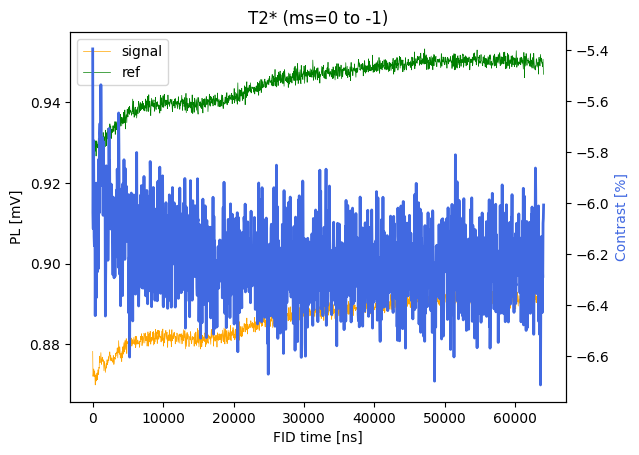

In [511]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
# ax1.plot(mw_dur, signal_av*1E3, linewidth=0.5, label="signal", color="orange")
# ax1.plot(mw_dur, background_av*1E3, linewidth=0.5, label="ref", color="green")
# ax2.plot(mw_dur, contrast*100.0, linewidth=2, label="contrast", color='royalblue')
idxstart = 0
idxend = len(fid_dur)
# idxend = 500
ax1.plot(fid_dur[idxstart:idxend], signal_av[idxstart:idxend]*1E3, linewidth=0.5, label="signal", color="orange")
ax1.plot(fid_dur[idxstart:idxend], background_av[idxstart:idxend]*1E3, linewidth=0.5, label="ref", color="green")
ax2.plot(fid_dur[idxstart:idxend], contrast[idxstart:idxend]*100.0, linewidth=2, label="contrast", color='royalblue')

ax1.set_xlabel("FID time [ns]")
ax1.set_ylabel("PL [mV]")
ax2.set_ylabel("Contrast [%]", color='royalblue')
ax1.legend(loc='best')
plt.title("T2* (ms=0 to -1)")
plt.savefig(f"{'.'.join(file_path.split('.')[0:-1])}.jpg")
plt.show()

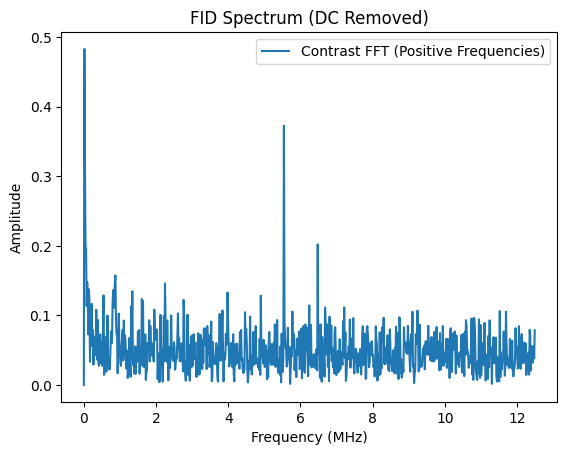

In [512]:

# File path
filename = filename
with open(file_path, 'rb') as f:
    data = pickle.load(f)

# Access the contrast data and time domain
contrast = data['contrast']
fid_dur = data['fid_dur']

# Remove the DC component (constant offset) by subtracting the mean
contrast_centered = contrast - np.mean(contrast)

# Perform the FFT after removing DC
# Convert fid_dur from nanoseconds to seconds for correct frequency calculation
sampling_interval = (fid_dur[1] - fid_dur[0]) * 1e-3  # Convert ns to us

# Compute FFT and corresponding frequencies
contrast_fft = np.fft.fft(contrast_centered)
frequencies = np.fft.fftfreq(len(contrast_centered), sampling_interval)

# Filter out the negative frequencies
positive_frequencies = frequencies[frequencies >= 0]
positive_fft = contrast_fft[frequencies >= 0]

# Plot only the positive frequencies
plt.figure()
plt.plot(positive_frequencies, np.abs(positive_fft), label='Contrast FFT (Positive Frequencies)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude')
plt.title('FID Spectrum (DC Removed)')
plt.legend()
plt.savefig(f"{'.'.join(file_path.split('.')[0:-1])}_fft.jpg")

In [513]:
print(f"{positive_frequencies[np.argmax(np.abs(positive_fft))]}MHz")

0.015615240474703309MHz


In [514]:
print(f"{positive_frequencies[np.argmax(np.abs(positive_fft))]}MHz")

0.015615240474703309MHz


In [515]:
pg.constant(OutputState.ZERO())
laser.laser_off() # turn off laser
readtask.close()
# mwsyn.reboot()

In [516]:
mwsyn.reboot()

MW Synthesizer Rebooted!


In [517]:
# close the communication
laser.close()
mwsyn.close()


In [518]:
pg.reset()

: 